# P4 - PREDICTION CONSOMMATION ELECTRIQUE DE BATIMENTS

<p><strong>Contexte :</strong> Le client <strong>"Ville de Seattle"</strong> souhaite atteindre son objectif de ville neutre en émissions de carbone d'ici 2050 et nous a missionner pour étudier les émissions des bâtiments <strong>non destinés à l’habitation</strong>.</p>

<p><strong>Problématique :</strong> Des relevés minutieux des consommations électriques ont été ainsi effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir.</p>

<p><strong>Objectifs :</strong></p>

<ul>
    <li>A partir de ces relevés, réaliser une <strong>prédiction</strong> des émissions de CO2 et de la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.</li>
    <li>Evaluer l’intérêt de l’<strong>ENERGY STAR Score</strong> pour la prédiction d’émissions, qui est fastidieux à calculer.</li>
</ul>

<hr/>

# *Partie 2 : Modélisation*

<hr/>

## I. Importation des Librairies utiles

In [1]:
# librairies pour ne pas montrer les warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# librairies pour les graphes
%matplotlib  inline
import matplotlib.pyplot as plt
import seaborn as sns

# librairies pour les analyses
import pandas as pd
import numpy as np
import missingno as msno
import math
from scipy import stats
from datetime import datetime

# librairies pour les modèles
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

<hr />

## II. Diverses fonctions

### 1. Importation des données

In [2]:
def concat_location(df):
    for i in df.index:
    # pour chaque ligne, parse la colonne "Location" en plusieurs colonnes vues dans df_2016  
        location = eval(df.loc[i,'Location']) # eval : converti string en dict
        adresse = eval(location['human_address'])
        df.loc[i,'Address'] = adresse['address']
        df.loc[i,'City'] = adresse['city']
        df.loc[i,'State'] = adresse['state']
        df.loc[i,'ZipCode'] = float(adresse['zip'])
        df.loc[i,'Latitude'] = location['latitude']
        df.loc[i,'Longitude'] = location['longitude']
    return df

In [3]:
def take_info(df):
    for i in df.index: 
        df.loc[i,'Age'] = df.loc[i,'DataYear'] - df.loc[i,'YearBuilt']
        adresse = df.loc[i,'Address'].split(' ')[1:]
        df.loc[i,'Street'] = ' '.join(adresse)
    return df

In [4]:
def import_data():
    df_2015 = pd.read_csv('../Dataset/2015-building-energy-benchmarking.csv')
    df_2015 = concat_location(df_2015)
    df_2015 = df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                                      'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',
                                      'Comment': 'Comments'
                                     })
    
    df_2016 = pd.read_csv('../Dataset/2016-building-energy-benchmarking.csv')
    df_all = df_2015.append(df_2016, ignore_index=True, sort=False)
    df_all = take_info(df_all)
    df_all = df_all[~df_all.BuildingType.str.contains('family')].reset_index(drop=True)
    
    return df_all

### 3. Selection des données

In [5]:
def select_data(df):
    selected_col = ['OSEBuildingID', 'BuildingType', 'Age', 'ZipCode',
                    'PrimaryPropertyType', 'LargestPropertyUseType', 'Neighborhood',
                    'NumberofBuildings', 'NumberofFloors',
                    'PropertyGFAParking', 'PropertyGFABuilding(s)',                
                    'ENERGYSTARScore',
                    'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
                    'TotalGHGEmissions', 'GHGEmissionsIntensity']
    df = df[selected_col]
    return df

### 4. Gestion des valeurs manquantes

In [6]:
def nan_string_replace(df):
    ''' Fonction qui prend en entrée un dataframe,
        identifie les valeurs manquantes pour les variables catégorielles,
        les remplace par la valeur "inconnu", et
        retourne le data après traitement
    '''    
    cat = [col for col in df.columns if (df[col].dtypes=='object')]
    cat.extend(['OSEBuildingID','ZipCode'])
    
    for col in cat:
        if col=='ZipCode':
            for i in df.index:
                if df.loc[i,col]==np.nan:
                    street = df.loc[i,'Street']
                    zipcode = df[df.Street==street][col].values[0]
                    df.loc[i,col] = zipcode
        else:
            df[col].fillna(value='inconnu', inplace=True)
    
    return df

In [7]:
def nan_float_replace(df):
    ''' Fonction qui prend en entrée un dataframe,
        identifie les valeurs manquantes pour les variables numeriques,
        les remplace par la médiane de cette variable filtré par le type de batiment, et
        retourne le data après traitement
    '''    

    var = [col for col in df.columns if (col not in ['OSEBuildingID','ZipCode'])
       & ((df[col].dtypes=='float64') | (df[col].dtypes=='int64'))]
    
    for col in var:
        for categ in df['BuildingType'].unique():
            mean_value = np.nanmedian(df.loc[(df['BuildingType']==categ),col])
            if math.isnan(mean_value):
                mean_value = np.nanmedian(df[col])
            df.loc[(df['BuildingType']==categ),col] = df.loc[(df['BuildingType']==categ),col].fillna(mean_value)
            
    return df

In [8]:
def treat_nan(df):
    df = nan_string_replace(df)
    df = nan_float_replace(df)
    return df

### 5. Gestion des outliers

In [9]:
def treat_outlier(df):
    ''' Fonction qui prend en entrée un dataframe,
        pour chaque variable quantitative identifie les outliers (valeurs en dehors de la distribution),
        les remplaces par la valeur NaN,
        et retourne le dataframe après traitement
    '''
    var = [col for col in df.columns if (col not in ['OSEBuildingID','ZipCode','NumberofBuildings','NumberofFloors'])
           & ((df[col].dtypes=='float64') | (df[col].dtypes=='int64'))]
    df_res = df.copy()
    index_outlier = []
    
    for col in var:
        zscores = pd.DataFrame(stats.zscore(df_res[col],nan_policy='omit'),columns=['value'])
        index_outlier.extend(zscores[(zscores.value>3) | (zscores.value<-3)].index)
    
    index_outlier = list(dict.fromkeys(index_outlier) ) 
    df_res.drop(index_outlier,inplace=True)
    
    return df_res

### 6. Transformation des données

In [10]:
def onehotencoding(df):
    cat = [col for col in df.columns if (df[col].dtypes=='object')]
    cat.extend(['ZipCode'])
    df_res = pd.get_dummies(data=df,columns=cat)
    return df_res

In [11]:
def normalisation(df):
    var_to_norm = ['SiteEUI(kBtu/sf)']
    for col in var_to_norm:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [12]:
def log_transform(df):
    var_to_log = ['PropertyGFAParking','PropertyGFABuilding(s)','SiteEnergyUse(kBtu)','SteamUse(kBtu)',
                  'TotalGHGEmissions']
    for col in var_to_log:
        df[col] = df.apply(lambda x: np.log(1 + x[col]) if np.log(1 + x[col]) > 0 else 0, axis=1)
    return df

In [13]:
def transform(df):
    df = normalisation(df)
    df = log_transform(df)
    df = onehotencoding(df)
    return df

### 7.  Feature engineering

In [14]:
def featureengineer():
    raw_data = select_data(import_data())
    nan_data = treat_nan(raw_data)
    out_data = treat_outlier(nan_data)
    final_data = transform(out_data)
    return(final_data,raw_data)

### 8. Séparation des données

In [15]:
def split_data(var_to_predict):
    X = data_to_model.values
    features = data_to_model.columns
    y = data[var_to_predict].values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3)
    return X_train, X_test, y_train, y_test

### 9. Essai et Evaluation de modèle

In [16]:
def try_model(name_model,model,var_to_predict):
    X_train, X_test, y_train, y_test = split_data(var_to_predict)
    
    # fit
    fit_start = datetime.now()
    model.fit(X_train,y_train)
    fit_end = datetime.now()
    
    # predict
    pred_start = datetime.now()
    y_pred = model.predict(X_test)
    pred_end = datetime.now()
    
    # evaluation score
    r2 = r2_score(y_test,y_pred) 
    mean_error = np.mean(y_pred - y_test)
    std_error = np.std(y_pred - y_test)
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_cv = list(cross_val_score(model,X_train,y_train,scoring='r2',cv=5))

    # evaluation time
    fit_time = fit_end - fit_start
    pred_time = pred_end - pred_start
    
    res = {'model':[name_model],
           'r2':[r2],'r2_cv':[r2_cv],'mean error':[mean_error],'std error':[std_error],'rmse':[rmse],
           'fit time':[fit_time],'pred time':[pred_time]}
    
    res_model = pd.DataFrame(data=res)
    
    return y_pred, res_model

### 10. Régularisation (Régression linéaire avec pénalités)

In [17]:
def regularise(name_model,alphas,x_train,y_train,x_test,y_test):
    coeff = []
    train_r2 = []
    test_r2 = []
    errors = []
    
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    baseline_error = np.mean((lr.predict(x_test) - y_test) ** 2)


    for a in alphas:
        if name_model=='ridge':
            mod = Ridge(alpha=a)
        elif name_model=='lasso':
            mod = Lasso(alpha=a)
        mod.fit(x_train, y_train)
        coeff.append(mod.coef_)
        train_r2.append(mod.score(x_train, y_train))
        test_r2.append(mod.score(x_test, y_test))
        errors.append([baseline_error, np.mean((mod.predict(x_test) - y_test) ** 2)])

    plt.figure(figsize=(20, 6))

    plt.subplot(131)
    ax = plt.gca()
    ax.plot(alphas, coeff)
    plt.xlabel('alphas')
    plt.ylabel('coefficients')
    plt.title(name_model + ' coefficients en fonction de la régularisation')
    plt.axis('tight')

    plt.subplot(132)
    ax = plt.gca()
    ax.plot(alphas, train_r2, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
    ax.plot(alphas, test_r2, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
    plt.xlabel('alphas')
    plt.ylabel(r'$R^2$')
    plt.title('Evaluation du modèle ' + name_model + ' regression avec differents alphas')
    plt.legend(loc='best')

    plt.subplot(133)
    ax = plt.gca()
    ax.plot(alphas, errors)
    ax.set_xscale('log')
    plt.xlabel('alphas')
    plt.ylabel('errors')
    plt.xlim(0,5)

### 11. Optimisation d'hyperparamètres

In [18]:
def gridsearch(name_model,model,X,y):
    if name_model in ['ridge','lasso']:
        params = {'alpha' : np.linspace(0,10,50)}
        
    elif name_model in ['randomforest','xgboost']: 
        params = {'max_depth' : np.linspace(1, 30, 30, dtype=int, endpoint=True),
                  'n_estimators': np.linspace(1, 20, 20, dtype=int, endpoint=True)}
    
    grid = GridSearchCV(estimator = model,
                        param_grid = params,
                        cv= 3, verbose=2, return_train_score=True)
    grid.fit(X,y)
    return grid

In [19]:
def res_grid(grid):
    ## Results from grid search
    results = grid.cv_results_
    mean_score = results['mean_test_score']
    std_score = results['std_test_score']
    mean_time_fit = results['mean_fit_time']
    std_time_fit = results['std_fit_time']  
    
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))
    
    return mean_score, std_score, mean_time_fit, std_time_fit, masks, masks_names

In [20]:
def plot_grid(grid,res):
    ## Results from grid search
    mean_score, std_score, mean_time_fit, std_time_fit, masks, masks_names = res_grid(grid)
    params=grid.param_grid
    
    ## Ploting results
    if res=='score':    
        fig, ax1 = plt.subplots(1,len(params),figsize=(20,5))
        fig.suptitle('Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(mean_score[best_index])
            e_1 = np.array(std_score[best_index])
            ax1[i].errorbar(x, y_1, e_1, linestyle='--', marker='o')
            ax1[i].set_xlabel(p.upper())
    elif res=='time': 
        fig, ax2 = plt.subplots(1,len(params),figsize=(20,5))
        fig.suptitle('Fit time per parameter')
        fig.text(0.04, 0.5, 'MEAN FIT TIME\n(secondes)', va='center', rotation='vertical')
        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(mean_time_fit[best_index])
            e_1 = np.array(std_time_fit[best_index])
            ax2[i].errorbar(x, y_1, e_1, linestyle='--', marker='o')
            ax2[i].set_xlabel(p.upper())

In [21]:
def plot_grids(grid1,grid2,name_model1,name_model2,res):
    ## Results from grid search
    mean_score1, std_score1, mean_time_fit1, std_time_fit1, masks1, masks_names1 = res_grid(grid1)
    params1=grid1.param_grid
    mean_score2, std_score2, mean_time_fit2, std_time_fit2, masks2, masks_names2 = res_grid(grid2)
    params2=grid2.param_grid
    
    ## Ploting results
    if res=='score':    
        fig, ax1 = plt.subplots(1,len(params1),figsize=(20,5))
        fig.suptitle('Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        for i, p in enumerate(masks_names1):
            m = np.stack(masks1[:i] + masks1[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x_1 = np.array(params1[p])
            y_1 = np.array(mean_score1[best_index])
            e_1 = np.array(std_score1[best_index])
            ax1[i].errorbar(x_1, y_1, e_1, linestyle='--', marker='o',label=name_model1)
        for i, p in enumerate(masks_names2):
            m = np.stack(masks2[:i] + masks2[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x_2 = np.array(params2[p])
            y_2 = np.array(mean_score2[best_index])
            e_2 = np.array(std_score2[best_index])
            ax1[i].errorbar(x_2, y_2, e_2, linestyle='--', marker='o',label=name_model2)
            ax1[i].set_xlabel(p.upper())
            ax1[i].set_ylabel('MEAN SCORE')
            ax1[i].legend()
    elif res=='time': 
        fig, ax2 = plt.subplots(1,len(params1),figsize=(20,5))
        fig.suptitle('Fit time per parameter')
        fig.text(0.04, 0.5, 'MEAN FIT TIME\n(secondes)', va='center', rotation='vertical')
        for i, p in enumerate(masks_names1):
            m = np.stack(masks1[:i] + masks1[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x_1 = np.array(params1[p])
            y_1 = np.array(mean_time_fit1[best_index])
            e_1 = np.array(std_time_fit1[best_index])
            ax2[i].errorbar(x_1, y_1, e_1, linestyle='--', marker='o',label=name_model1)
        for i, p in enumerate(masks_names2):
            m = np.stack(masks2[:i] + masks2[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x_2 = np.array(params2[p])
            y_2 = np.array(mean_time_fit2[best_index])
            e_2 = np.array(std_time_fit2[best_index])
            ax2[i].errorbar(x_2, y_2, e_2, linestyle='--', marker='o',label=name_model2)
            ax2[i].set_xlabel(p.upper())
            ax2[i].set_ylabel('MEAN FIT TIME\n(secondes)')
            ax2[i].legend()

<hr/>

## III. Modélisation

- **Importation et Préparation des données**

In [22]:
data,raw_data = featureengineer()
data_to_model = data[data.columns.difference(['TotalGHGEmissions','SiteEnergyUse(kBtu)'])]

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [23]:
# features
X = data_to_model.values
features = data_to_model.columns

# variable emission de CO2
emis = 'TotalGHGEmissions'
ye = data[emis].values

# variable consommation d'énergie
conso = 'SiteEnergyUse(kBtu)'
yc = data[conso].values

- **Initialisation de plusieurs modèles**

In [24]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
dummy = DummyRegressor()
randomforest = RandomForestRegressor()
XGBoost = xgboost.XGBRegressor()

In [25]:
models = {'linear':linear,'ridge':ridge,'lasso':lasso,
          'dummy':dummy,'randomforest':randomforest,'XGBoost':XGBoost}

### A. EMISSIONS DE CO2

- **Séparation des données**

In [26]:
# 30% des données dans le jeu de test
Xe_train, Xe_test, ye_train, ye_test = model_selection.train_test_split(X,ye,test_size=0.3)

- **Essais des plusieurs modèles**

In [27]:
emis_models = pd.DataFrame(columns=['model','r2','mean error','std error','rmse','fit time','pred time'])

for name,model in models.items():
    y_pred, res = try_model(name,model,emis)
    emis_models = emis_models.append(res)

In [28]:
emis_models

,model,r2,mean error,std error,rmse,fit time,pred time,r2_cv
0,linear,-4.633807e+10,-16669.205414,290376.413869,290854.472444,0 days 00:00:00.103882,0 days 00:00:00.006677,"[-29224941333747.402, 0.8060308539902012, 0.78..."
0,ridge,7.968787e-01,0.017684,0.596694,0.596956,0 days 00:00:00.014094,0 days 00:00:00.000512,"[0.7444219696445493, 0.6870970906237612, 0.818..."
0,lasso,2.302582e-01,-0.064158,1.174432,1.176183,0 days 00:00:00.010845,0 days 00:00:00.000571,"[0.28994356812044986, 0.23238159716207996, 0.2..."
0,dummy,-1.499404e-03,-0.050547,1.305374,1.306352,0 days 00:00:00.000453,0 days 00:00:00.000099,"[-0.002846875597795062, -0.0029456956502962317..."
0,randomforest,9.806254e-01,-0.007276,0.185636,0.185778,0 days 00:00:03.193553,0 days 00:00:00.038594,"[0.9758453137296385, 0.9843439407115906, 0.982..."
0,XGBoost,9.817005e-01,-0.005098,0.180795,0.180867,0 days 00:00:22.594098,0 days 00:00:00.016033,"[0.9763055316694904, 0.9763437127902298, 0.960..."


***Observations:***
<p>- Les modèles Linéaire simple et Dummy ne sont pas adéquats pour modéliser les données (R2 non conforme).
<p>- Le modèle avec pénalités Lasso semble convenir mais présente un R2 moyen. On ne le retiendra pas.
<p>- Le modèle avec pénalités Ridge semble convenir, il faut approfondir leur caractère selon alphas.
<p>- Les modèles Random Forest et Xgboost semblent pertinents avec des R2 bons, on les retiendra pour la suite.

- **Régularisation du modèle Ridge**

In [29]:
alphas = np.linspace(0.01,5,201)

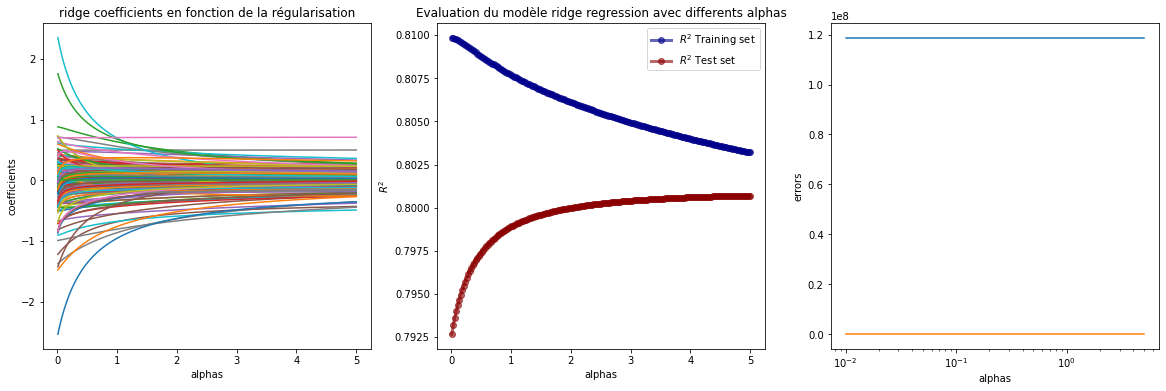

In [30]:
regularise('ridge',alphas,Xe_train,ye_train,Xe_test,ye_test)

***Observations:***
<p>Les coefficients se stabilisent pour des alphas > 0 avec des R2 correctes.

- **Optimisation des hyperparamètres pour les 2 modèles retenus**

In [31]:
emis_rg_grid = gridsearch('ridge',ridge,X,ye)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ..........................................alpha=0.0; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.1s
[CV] END ..........................................alpha=0.0; total time=   0.1s
[CV] END ..........................alpha=0.20408163265306123; total time=   0.0s
[CV] END ..........................alpha=0.20408163265306123; total time=   0.0s
[CV] END ..........................alpha=0.20408163265306123; total time=   0.0s
[CV] END ..........................alpha=0.40816326530612246; total time=   0.0s
[CV] END ..........................alpha=0.40816326530612246; total time=   0.0s
[CV] END ..........................alpha=0.40816326530612246; total time=   0.1s
[CV] END ...........................alpha=0.6122448979591837; total time=   0.0s
[CV] END ...........................alpha=0.6122448979591837; total time=   0.0s
[CV] END ...........................alpha=0.612

[CV] END ............................alpha=7.142857142857143; total time=   0.0s
[CV] END ............................alpha=7.142857142857143; total time=   0.0s
[CV] END ............................alpha=7.142857142857143; total time=   0.0s
[CV] END ............................alpha=7.346938775510204; total time=   0.0s
[CV] END ............................alpha=7.346938775510204; total time=   0.0s
[CV] END ............................alpha=7.346938775510204; total time=   0.0s
[CV] END ............................alpha=7.551020408163265; total time=   0.0s
[CV] END ............................alpha=7.551020408163265; total time=   0.0s
[CV] END ............................alpha=7.551020408163265; total time=   0.0s
[CV] END ............................alpha=7.755102040816327; total time=   0.0s
[CV] END ............................alpha=7.755102040816327; total time=   0.0s
[CV] END ............................alpha=7.755102040816327; total time=   0.0s
[CV] END ...................

In [32]:
emis_rf_grid = gridsearch('randomforest',randomforest,X,ye)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1,

[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END ...................

[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=13; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=13; total time=   0.2s
[CV] END ...................

[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=7; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=7; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=7; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=8; total time=   0.1s
[CV] END ...................

[CV] END .......................max_depth=7, n_estimators=18; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.3s
[CV] END ........................max_depth=8, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=8, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=8, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=8, n_estimators=2; total time=   0.1s
[CV] END ...................

[CV] END .......................max_depth=9, n_estimators=12; total time=   0.4s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=9, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END ...................

[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END ......................max_depth=11, n_estimators=10; total time=   0.3s
[CV] END ...................

[CV] END ......................max_depth=12, n_estimators=20; total time=   0.7s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.6s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=4; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=14, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.6s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.6s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=18; total time=   0.7s
[CV] END ...................

[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=12; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=18, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=6; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=19, n_estimators=16; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=20; total time=   0.6s
[CV] END ...................

[CV] END ......................max_depth=21, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=14; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=23, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.3s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.3s
[CV] END ...................

[CV] END ......................max_depth=24, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.7s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=26, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=16; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=28, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.4s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.3s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.3s
[CV] END ...................

[CV] END ......................max_depth=29, n_estimators=20; total time=   0.6s
[CV] END ......................max_depth=29, n_estimators=20; total time=   0.6s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END ...................

In [33]:
emis_xg_grid = gridsearch('xgboost',XGBoost,X,ye)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.2s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.2s
[CV] END ........................max_depth=1,

[CV] END .......................max_depth=2, n_estimators=14; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.4s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END ...................

[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=13; total time=   0.1s
[CV] END ...................

[CV] END ........................max_depth=6, n_estimators=3; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=7; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=7; total time=   0.1s
[CV] END ...................

[CV] END .......................max_depth=7, n_estimators=17; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.2s
[CV] END ........................max_depth=8, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=8, n_estimators=1; total time=   0.0s
[CV] END ...................

[CV] END .......................max_depth=9, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.4s
[CV] END .......................max_depth=9, n_estimators=15; total time=   2.8s
[CV] END .......................max_depth=9, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=15; total time=   0.2s
[CV] END ...................

[CV] END .......................max_depth=11, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=12, n_estimators=20; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=14, n_estimators=14; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.8s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=16, n_estimators=12; total time=   0.3s
[CV] END ...................

[CV] END .......................max_depth=18, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=6; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=19, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=20; total time=   0.6s
[CV] END ...................

[CV] END ......................max_depth=21, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=10; total time=   0.5s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.5s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.6s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.6s
[CV] END ......................max_depth=21, n_estimators=14; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=23, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.3s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=24, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.9s
[CV] END ......................max_depth=24, n_estimators=20; total time=   1.1s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.7s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.1s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.0s
[CV] END ...................

[CV] END ......................max_depth=26, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.3s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.3s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.6s
[CV] END ......................max_depth=26, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=16; total time=   0.6s
[CV] END ...................

[CV] END .......................max_depth=28, n_estimators=7; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.7s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.2s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.9s
[CV] END ...................

[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.2s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.4s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.6s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=30, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=5; total time=   0.1s
[CV] END ...................

- **Comparaison des 3 modèles**

In [34]:
emis_brg = emis_rg_grid.best_estimator_
emis_brf = emis_rf_grid.best_estimator_
emis_bxg = emis_xg_grid.best_estimator_

In [35]:
bmodels = {'ridge':emis_brg,'randomforest':emis_brf,'XGBoost':emis_bxg}

In [36]:
emis_bmodels = pd.DataFrame(columns=['model','r2','mean error','std error','rmse','fit time','pred time'])

for name,model in bmodels.items():
    y_pred, res = try_model(name,model,conso)
    emis_bmodels = emis_bmodels.append(res)

In [37]:
emis_bmodels

,model,r2,mean error,std error,rmse,fit time,pred time,r2_cv
0,ridge,0.653548,-0.055398,0.821900,0.823765,0 days 00:00:00.008514,0 days 00:00:00.011409,"[0.5829921060094951, 0.45634528072165303, 0.35..."
0,randomforest,0.958735,-0.008497,0.354336,0.354438,0 days 00:00:00.398642,0 days 00:00:00.004671,"[0.9808355607632565, 0.9805930186307261, 0.984..."
0,XGBoost,0.984215,-0.006154,0.184564,0.184667,0 days 00:00:00.269542,0 days 00:00:00.004531,"[0.9887244860307405, 0.9754479392181292, 0.988..."


***Observations:***
<p>R2 du modèle ridge est plus faible que pour les 2 autres modèles => On ne retiendra pas ce modèle.

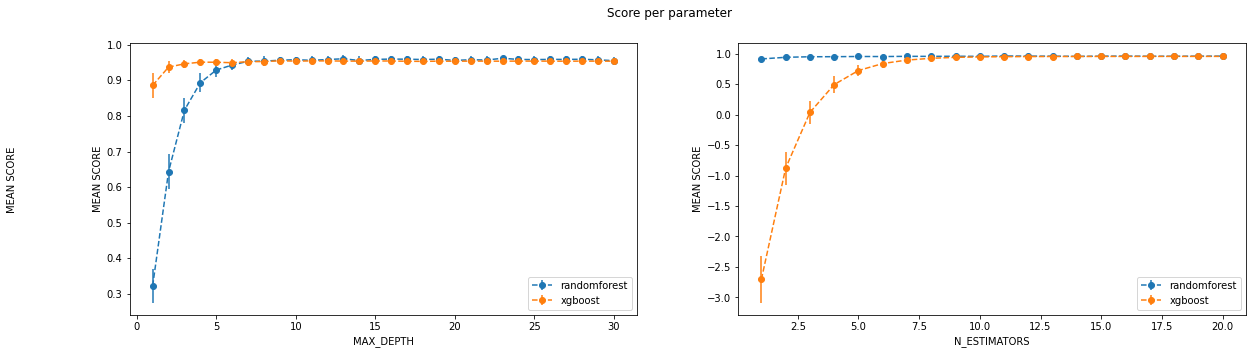

In [38]:
plot_grids(emis_rf_grid,emis_xg_grid,'randomforest','xgboost','score')

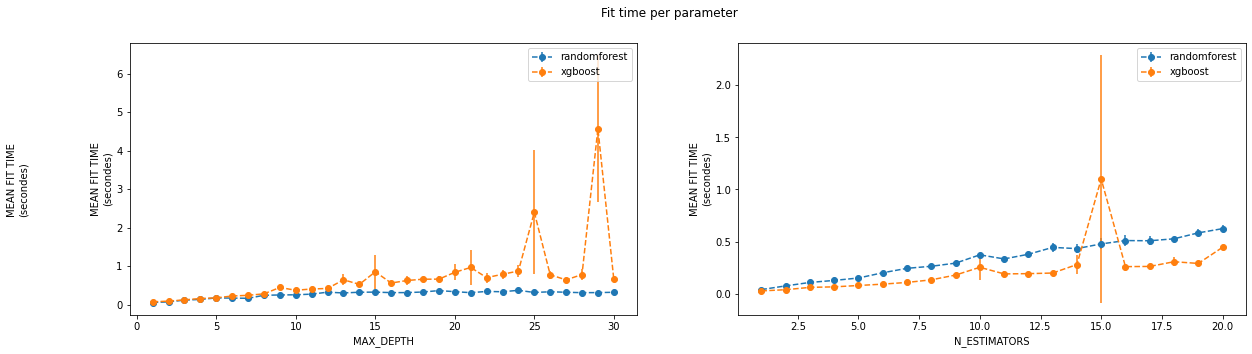

In [39]:
plot_grids(emis_rf_grid,emis_xg_grid,'randomforest','xgboost','time')

- **Features Importances selon le modèle**

In [40]:
emis_fimp = pd.DataFrame(columns=features,index=['random_forest','xgboost'])
emis_fimp.loc['random_forest'] = emis_brf.feature_importances_
emis_fimp.loc['xgboost'] = emis_bxg.feature_importances_

In [41]:
emis_brf_fimp = emis_fimp.T.sort_values(by = 'random_forest',ascending = False)['random_forest'][0:10]
emis_bxg_fimp = emis_fimp.T.sort_values(by = 'xgboost',ascending = False)['xgboost'][0:10]

Text(0.5, 0.98, 'Features importances')

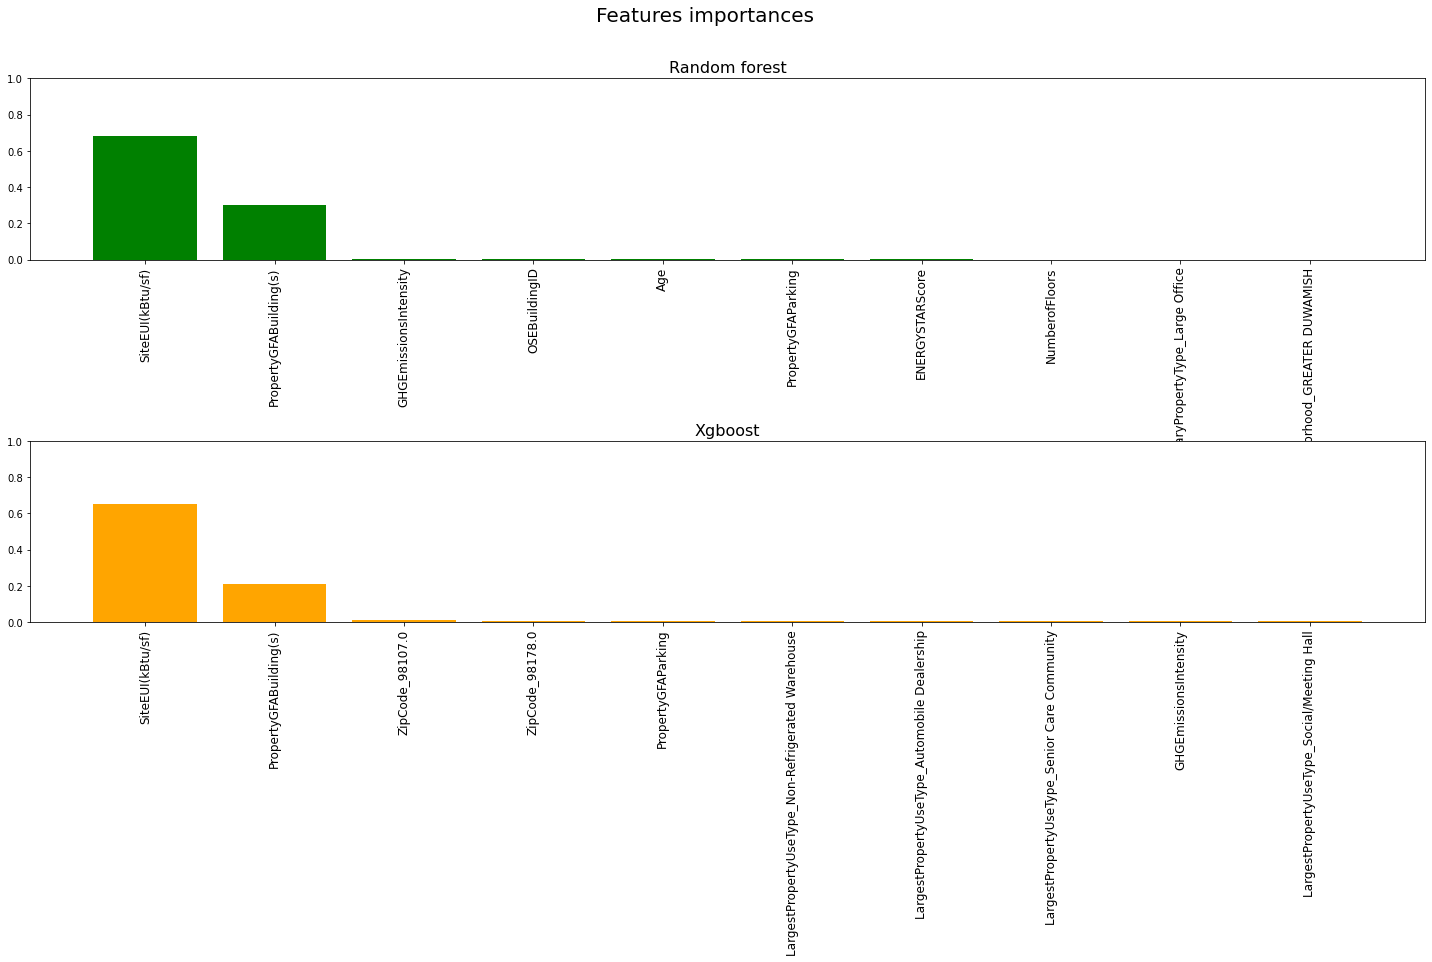

In [66]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(25,10),gridspec_kw={'hspace':1})
    
ax1.bar(range(len(emis_brf_fimp.values)), emis_brf_fimp.values,color='green')
ax1.set_ylim(0,1)
ax1.set_xticks(range(len(emis_brf_fimp.values)))
ax1.set_xticklabels(emis_brf_fimp.index,rotation=90,fontsize=12)
ax1.set_title('Random forest',fontsize=16)

ax2.bar(range(len(emis_bxg_fimp.values)), emis_bxg_fimp.values,color='orange')
ax2.set_ylim(0,1)
ax2.set_xticks(range(len(emis_bxg_fimp.values)))
ax2.set_xticklabels(emis_bxg_fimp.index,rotation=90,fontsize=12)
ax2.set_title('Xgboost',fontsize=16)

fig.suptitle('Features importances',fontsize=20)

Text(0.5, 1.0, 'Features importances in CO2 Emissions')

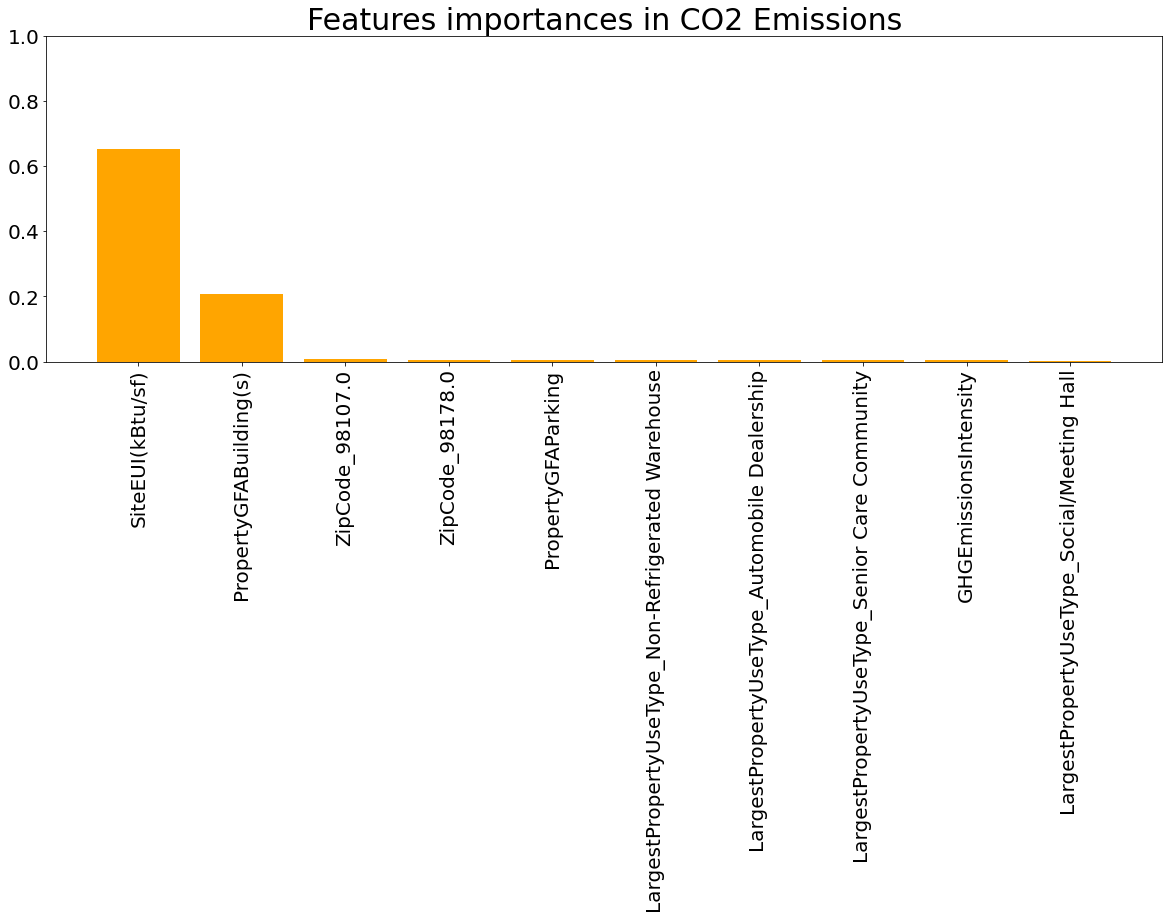

In [67]:
plt.figure(figsize=(20, 6))

plt.bar(range(len(emis_bxg_fimp.values)), emis_bxg_fimp.values,color='orange')
plt.ylim(0,1)
plt.yticks(fontsize=20)
plt.xticks(range(len(emis_bxg_fimp.values)),labels=emis_bxg_fimp.index,rotation=90,fontsize=20)
plt.title('Features importances in CO2 Emissions',fontsize=30)

- **Importance de ENERGYSTARScore selon le modèle**

In [43]:
emis_fimp['ENERGYSTARScore']

random_forest    0.000958
xgboost          0.001199
Name: ENERGYSTARScore, dtype: object

<hr/>

### B. CONSOMMATION D'ENERGIE

- **Séparation des données**

In [44]:
# 30% des données dans le jeu de test
Xc_train, Xc_test, yc_train, yc_test = model_selection.train_test_split(X,yc,test_size=0.3)

- **Essais des plusieurs modèles**

In [45]:
conso_models = pd.DataFrame(columns=['model','r2','mean error','std error','rmse','fit time','pred time'])

for name,model in models.items():
    y_pred, res = try_model(name,model,conso)
    conso_models = conso_models.append(res)

In [46]:
conso_models

,model,r2,mean error,std error,rmse,fit time,pred time,r2_cv
0,linear,-1.089801e+09,-2743.170011,59022.439439,59086.151839,0 days 00:00:00.043161,0 days 00:00:00.015698,"[0.6871740245589335, -251194852581.39627, 0.43..."
0,ridge,4.777843e-01,-0.053327,1.086438,1.087746,0 days 00:00:00.017793,0 days 00:00:00.001481,"[0.43834514467231334, 0.40982257709607817, 0.5..."
0,lasso,1.543760e-01,0.007837,1.555125,1.555145,0 days 00:00:00.015785,0 days 00:00:00.007080,"[0.30226149967181815, 0.040965781518480404, 0...."
0,dummy,-1.182469e-03,-0.044402,1.291252,1.292015,0 days 00:00:00.000533,0 days 00:00:00.000103,"[-0.0023429349213355266, -0.001605872824299359..."
0,randomforest,9.898144e-01,0.000383,0.173552,0.173552,0 days 00:00:03.178424,0 days 00:00:00.033756,"[0.9821910088565635, 0.9822443672393822, 0.984..."
0,XGBoost,9.414576e-01,-0.013676,0.350379,0.350646,0 days 00:00:01.090498,0 days 00:00:00.006045,"[0.9804390320201267, 0.9870484222395715, 0.987..."


***Observations:***
<p>- Le modèle Dummy n'est pas adéquats pour modéliser les données (R2 non conforme).
<p>- Le modèle avec pénalités Lasso n'est pas pertinent (R2 très faible).
<p>- Le modèle linéaire simple et celui avec pénalités Ridge semblent convenir mais présentent des R2 moins bons que pour les 2 derniers modèles.
<p>- Les modèles Random Forest et Xgboost semblent pertinents avec des R2 très bons.
<p> ====>on ne retiendra pour la suite que Random Forest et Xgboost.

- **Optimisation des hyperparamètres des modèles**

In [47]:
conso_rf_grid = gridsearch('randomforest',randomforest,X,yc)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1,

[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END ...................

[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.2s
[CV] END ...................

[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ...................

[CV] END .......................max_depth=7, n_estimators=17; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=17; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=17; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.3s
[CV] END ...................

[CV] END .......................max_depth=11, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=11, n_estimators=9; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=12, n_estimators=19; total time=   0.5s
[CV] END ......................max_depth=12, n_estimators=19; total time=   0.5s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.5s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.5s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.6s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=13, n_estimators=3; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=14, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.6s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=14, n_estimators=17; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=16, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.3s
[CV] END ...................

[CV] END .......................max_depth=18, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.2s
[CV] END ...................

[CV] END ......................max_depth=19, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=16; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.7s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.6s
[CV] END ...................

[CV] END ......................max_depth=21, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.5s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=23, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.3s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.3s
[CV] END ...................

[CV] END ......................max_depth=24, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=18; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.7s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.7s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=26, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=12; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=16; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=28, n_estimators=6; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.3s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.3s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.5s
[CV] END ...................

[CV] END ......................max_depth=29, n_estimators=20; total time=   0.6s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END ...................

In [48]:
conso_xg_grid = gridsearch('xgboost',XGBoost,X,yc)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=4; total time=   0.0s
[CV] END ........................max_depth=1,

[CV] END .......................max_depth=2, n_estimators=14; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=16; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=17; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=18; total time=   0.1s
[CV] END ...................

[CV] END ........................max_depth=4, n_estimators=8; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=12; total time=   0.3s
[CV] END ...................

[CV] END ........................max_depth=6, n_estimators=2; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=6; total time=   0.1s
[CV] END ...................

[CV] END .......................max_depth=7, n_estimators=17; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=17; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=17; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=18; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=19; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.2s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.3s
[CV] END .......................max_depth=7, n_estimators=20; total time=   0.3s
[CV] END ...................

[CV] END .......................max_depth=9, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=12; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=13; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=14; total time=   0.2s
[CV] END ...................

[CV] END .......................max_depth=11, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=11, n_estimators=8; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=12, n_estimators=19; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=19; total time=   0.3s
[CV] END ......................max_depth=12, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.3s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.6s
[CV] END ......................max_depth=12, n_estimators=20; total time=   0.8s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=13, n_estimators=2; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=14, n_estimators=13; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=13; total time=   0.2s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.2s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=14; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.2s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.2s
[CV] END ......................max_depth=14, n_estimators=15; total time=   0.4s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=16; total time=   1.3s
[CV] END ......................max_depth=14, n_estimators=16; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=16, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=8; total time=   0.4s
[CV] END .......................max_depth=16, n_estimators=9; total time=   1.1s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=16, n_estimators=9; total time=   0.1s
[CV] END ......................max_depth=16, n_estimators=10; total time=   1.9s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=16, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=16, n_estimators=11; total time=   0.2s
[CV] END ...................

[CV] END .......................max_depth=18, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=5; total time=   0.1s
[CV] END .......................max_depth=18, n_estimators=6; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=19, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=16; total time=   0.3s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=17; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=18; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=18; total time=   1.4s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.5s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=19; total time=   0.4s
[CV] END ......................max_depth=19, n_estimators=20; total time=   0.5s
[CV] END ...................

[CV] END ......................max_depth=21, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=21, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.2s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.2s
[CV] END ......................max_depth=21, n_estimators=12; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=21, n_estimators=13; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=14; total time=   0.3s
[CV] END ......................max_depth=21, n_estimators=14; total time=   0.5s
[CV] END ...................

[CV] END .......................max_depth=23, n_estimators=4; total time=   0.5s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.8s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.5s
[CV] END .......................max_depth=23, n_estimators=5; total time=   0.7s
[CV] END .......................max_depth=23, n_estimators=6; total time=   0.8s
[CV] END .......................max_depth=23, n_estimators=6; total time=   1.0s
[CV] END .......................max_depth=23, n_estimators=6; total time=   1.0s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.4s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=23, n_estimators=8; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=24, n_estimators=18; total time=   0.9s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.6s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.5s
[CV] END ......................max_depth=24, n_estimators=19; total time=   0.5s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.5s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.9s
[CV] END ......................max_depth=24, n_estimators=20; total time=   0.9s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=25, n_estimators=2; total time=   0.0s
[CV] END ...................

[CV] END ......................max_depth=26, n_estimators=12; total time=   0.5s
[CV] END ......................max_depth=26, n_estimators=13; total time=   0.4s
[CV] END ......................max_depth=26, n_estimators=13; total time=   1.0s
[CV] END ......................max_depth=26, n_estimators=13; total time=   2.3s
[CV] END ......................max_depth=26, n_estimators=14; total time=   4.8s
[CV] END ......................max_depth=26, n_estimators=14; total time=   1.2s
[CV] END ......................max_depth=26, n_estimators=14; total time=   0.6s
[CV] END ......................max_depth=26, n_estimators=15; total time=   1.6s
[CV] END ......................max_depth=26, n_estimators=15; total time=   3.6s
[CV] END ......................max_depth=26, n_estimators=15; total time=   0.7s
[CV] END ......................max_depth=26, n_estimators=16; total time=   1.8s
[CV] END ......................max_depth=26, n_estimators=16; total time=   0.4s
[CV] END ...................

[CV] END .......................max_depth=28, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.2s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=7; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=8; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.1s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.9s
[CV] END .......................max_depth=28, n_estimators=9; total time=   0.1s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=28, n_estimators=10; total time=   0.3s
[CV] END ...................

[CV] END ......................max_depth=29, n_estimators=20; total time=   0.6s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=2; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END .......................max_depth=30, n_estimators=4; total time=   0.1s
[CV] END ...................

- **Comparaison des 2 modèles**

In [49]:
conso_brf = conso_rf_grid.best_estimator_
conso_bxg = conso_xg_grid.best_estimator_

In [50]:
bmodels = {'randomforest':conso_brf,'XGBoost':conso_bxg}

In [51]:
conso_bmodels = pd.DataFrame(columns=['model','r2','mean error','std error','rmse','fit time','pred time'])

for name,model in bmodels.items():
    y_pred, res = try_model(name,model,conso)
    conso_bmodels = conso_bmodels.append(res)

In [52]:
conso_bmodels

,model,r2,mean error,std error,rmse,fit time,pred time,r2_cv
0,randomforest,0.989542,-0.003059,0.177881,0.177907,0 days 00:00:00.652112,0 days 00:00:00.008625,"[0.9880439524892828, 0.9866825708725907, 0.836..."
0,XGBoost,0.975619,-0.013402,0.215618,0.216034,0 days 00:00:01.845284,0 days 00:00:00.004803,"[0.9836754191173357, 0.9003851142830899, 0.988..."


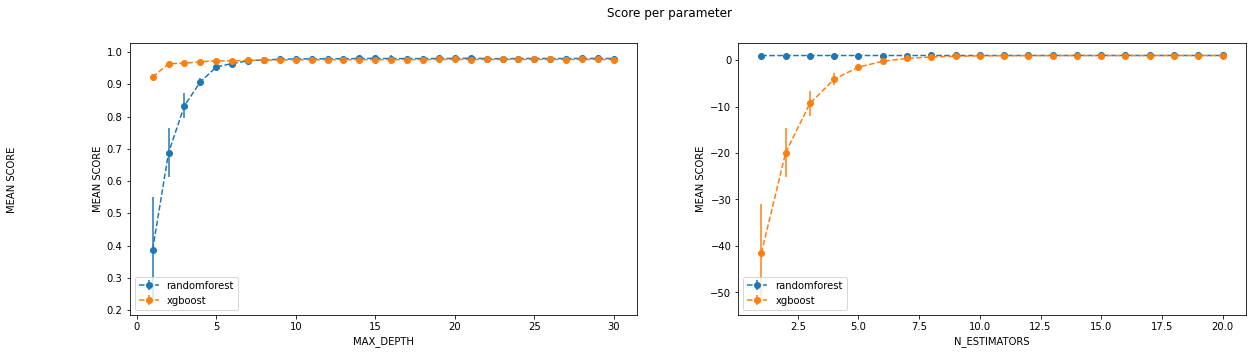

In [53]:
plot_grids(conso_rf_grid,conso_xg_grid,'randomforest','xgboost','score')

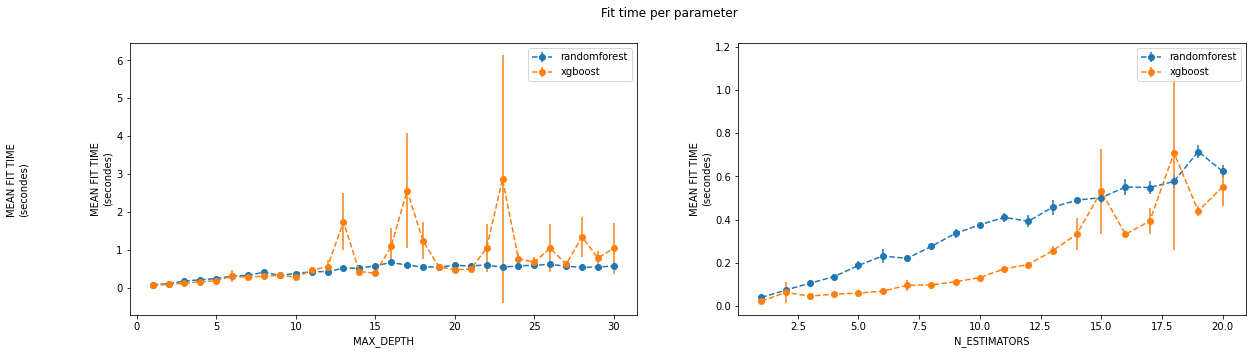

In [54]:
plot_grids(conso_rf_grid,conso_xg_grid,'randomforest','xgboost','time')

- **Features Importances selon le modèle**

In [55]:
conso_fimp = pd.DataFrame(columns=features,index=['random_forest','xgboost'])
conso_fimp.loc['random_forest'] = conso_brf.feature_importances_
conso_fimp.loc['xgboost'] = conso_bxg.feature_importances_

In [56]:
conso_brf_fimp = conso_fimp.T.sort_values(by = 'random_forest',ascending = False)['random_forest'][0:10]
conso_bxg_fimp = conso_fimp.T.sort_values(by = 'xgboost',ascending = False)['xgboost'][0:10]

Text(0.5, 0.98, 'Features importances')

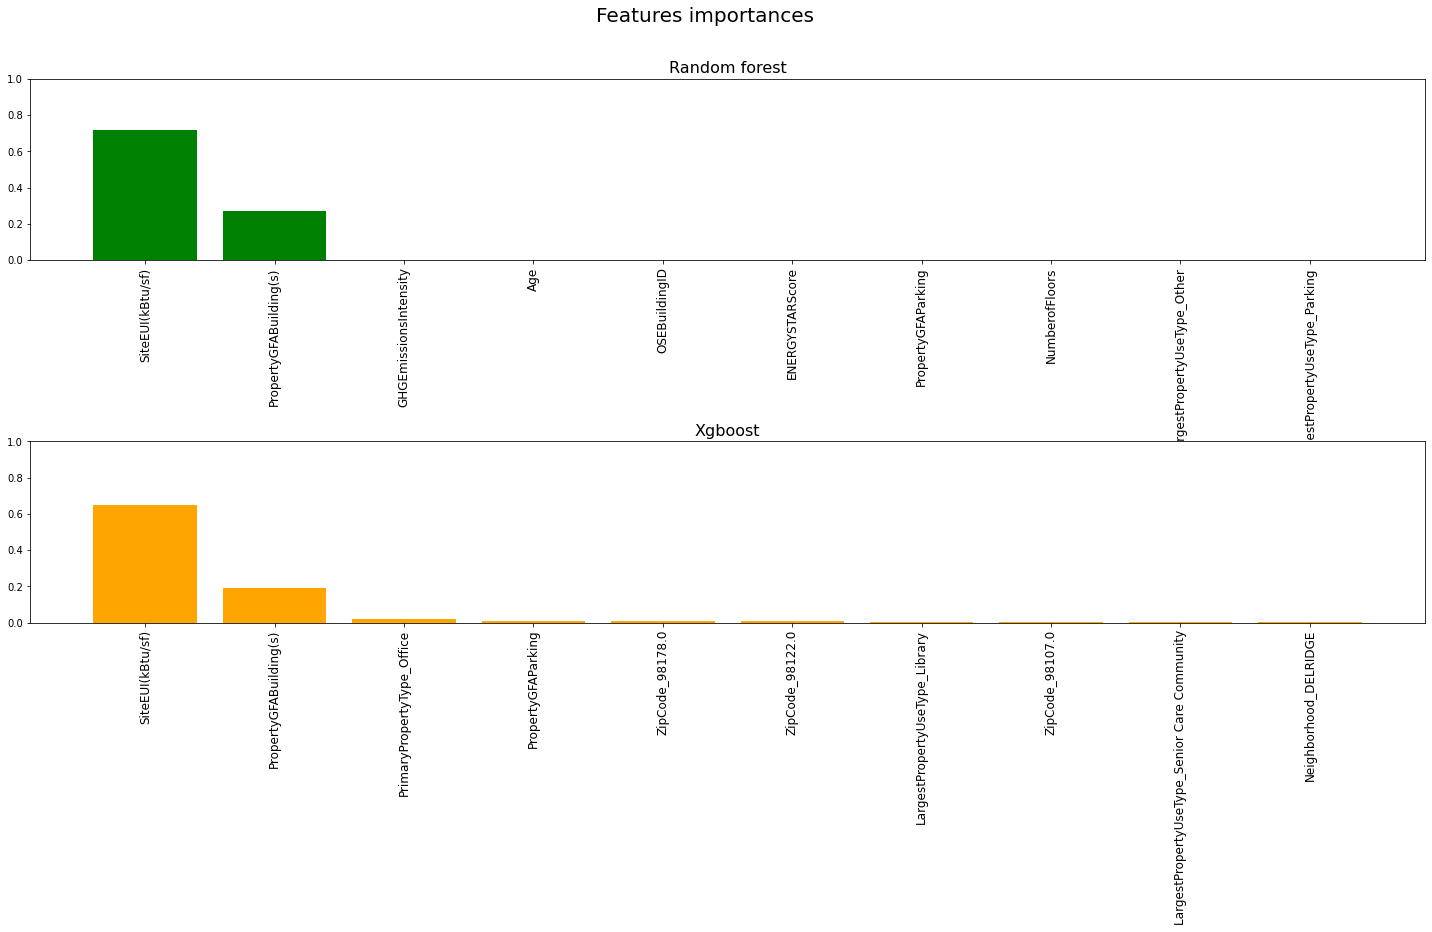

In [57]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(25,10),gridspec_kw={'hspace':1})
    
ax1.bar(range(len(conso_brf_fimp.values)), conso_brf_fimp.values,color='green')
ax1.set_ylim(0,1)
ax1.set_xticks(range(len(conso_brf_fimp.values)))
ax1.set_xticklabels(conso_brf_fimp.index,rotation=90,fontsize=12)
ax1.set_title('Random forest',fontsize=16)

ax2.bar(range(len(conso_bxg_fimp.values)), conso_bxg_fimp.values,color='orange')
ax2.set_ylim(0,1)
ax2.set_xticks(range(len(conso_bxg_fimp.values)))
ax2.set_xticklabels(conso_bxg_fimp.index,rotation=90,fontsize=12)
ax2.set_title('Xgboost',fontsize=16)

fig.suptitle('Features importances',fontsize=20)

Text(0.5, 1.0, 'Features importances in Energy Consommation')

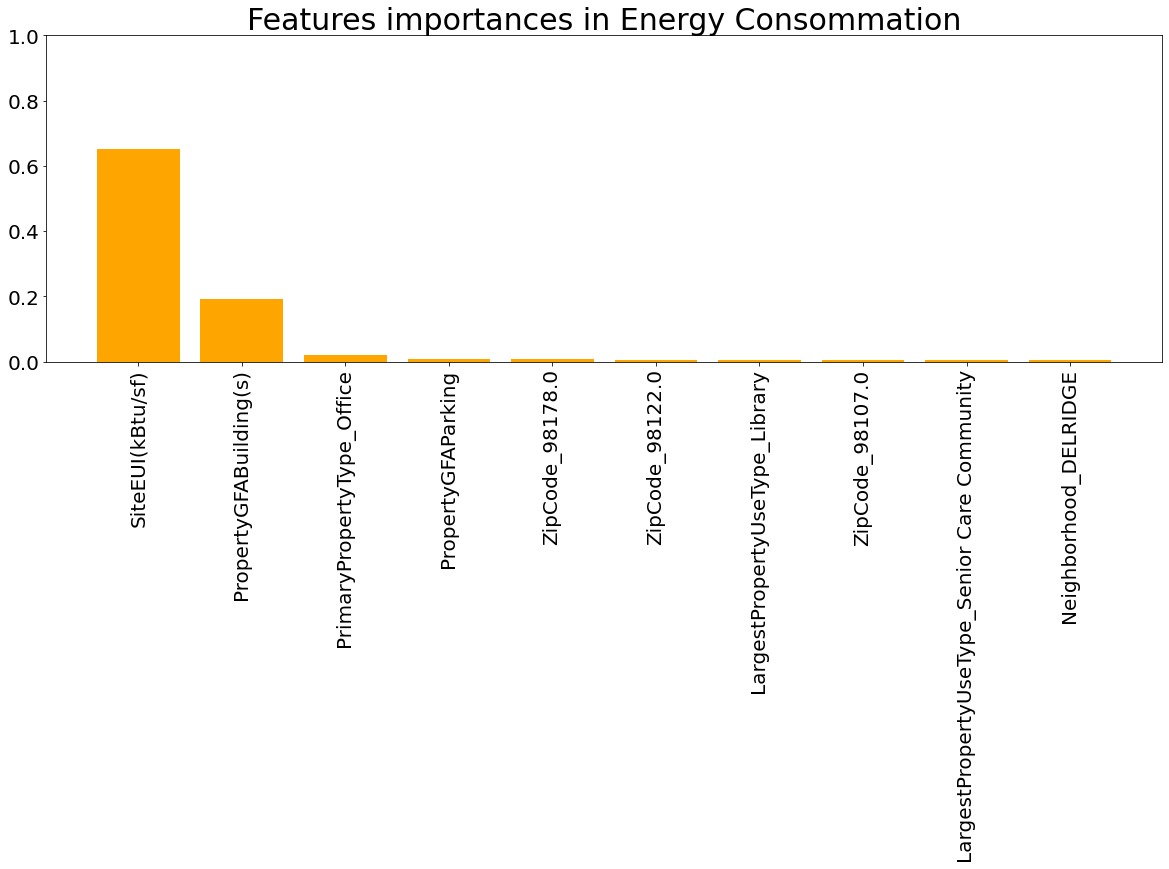

In [64]:
plt.figure(figsize=(20, 6))

plt.bar(range(len(conso_bxg_fimp.values)), conso_bxg_fimp.values,color='orange')
plt.ylim(0,1)
plt.yticks(fontsize=20)
plt.xticks(range(len(conso_bxg_fimp.values)),labels=conso_bxg_fimp.index,rotation=90,fontsize=20)
plt.title('Features importances in Energy Consommation',fontsize=30)

- **Importance de ENERGYSTARScore selon le modèle**

In [58]:
conso_fimp['ENERGYSTARScore']

random_forest    0.001026
xgboost          0.000663
Name: ENERGYSTARScore, dtype: object